In [11]:
import copy
!python -m pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [2]:
%cd ~
%cd ../../disk2/jl/jl/data_analyzing_tool

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from data_prepare.data_preprocess import prepareData_accWithSTFT_2d

/home/eis/anaconda3/envs/jl_maa/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/eis/anaconda3/envs/jl_maa/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/eis
/disk2/jl/jl/data_analyzing_tool


In [3]:
%load_ext autoreload
%autoreload 
from data_prepare.data_prepare_manager import select_dataset

dataset_name = "cifar-10"
dataset_A, classes_A = select_dataset(dataset_name)

dataset_name = "cifar-10_jitter"
dataset_B, classes_B = select_dataset(dataset_name)

dataset_name = "cifar-10_rotate"
dataset_C, classes_C = select_dataset(dataset_name)

dataset_name = "cifar-10_noise"
dataset_D, classes_D = select_dataset(dataset_name)

All CIFAR-10 files are present.
Computed mean: [125.30691805 122.95039414 113.86538318]
Computed std: [62.99321928 62.08870764 66.70489964]
All CIFAR-10 files are present.
CIFAR-10 loaded.
All CIFAR-10 files are present.
CIFAR-10 loaded.
All CIFAR-10 files are present.
CIFAR-10 loaded.


In [4]:

from model_structure.cnn_model_2d import CNN2D

classes = classes_A = classes_B = classes_C = classes_D
num_classes = len(classes)
print(num_classes)
# from model_structure.testNN_wo_softmax import testNN_wo_Softmax
# model = testNN_wo_Softmax(outputClasses=num_classes)

from model_structure.testModel_wo_softmax_5_layer import testNN_wo_Softmax_5_layer
model = testNN_wo_Softmax_5_layer(outputClasses=num_classes)
# model = CNN2D(num_classes=9)
# pth_path = './trained_pth/rootModel-da 1 - 0.pth'
# pth_path = './trained_pth/best_model_pretrain-1734930660.pth'

# CLustered Pick
'''
pth_path_list = ['./trained_pth/rootModel-fed_avg - MD Mixed | RP.pth',
                 './trained_pth/rootModel-fed_prox - MD Mixed | RP | Mu 0.001.pth',
                 './trained_pth/rootModel-fisher_client - MD Mixed | RP | Mu 2.0.pth',
                 './trained_pth/rootModel-fisher_server - MD Mixed | RP | Mu 1.0.pth',
                 './trained_pth/rootModel-DA| weighted fed_avg_param_diff - MD Mixed | RP.pth']
'''

'''
pth_path_list = ['./trained_pth/rootModel-fed_avg - MD Mixed | RP.pth',
                 './trained_pth/rootModel-fed_prox - MD Mixed | RP | Mu 0.001.pth',
                 './trained_pth/rootModel-DA| weighted fed_avg_param_diff - MD Mixed | RP.pth']
'''

pth_path_list = ['./trained_pth/rootModel-fed_avg_more_filters - MD Mixed | RP.pth']
# pth_path_list = ['./trained_pth/rootModel-fed_avg_5_layer - MD Mixed | RP.pth']


# './trained_pth/rootModel-fed_avg - SD_original | RP.pth',

10


In [5]:
################################################
# 1. Hook을 걸어서 전체 데이터셋 Feature를 추출 #
################################################

features = []  # 전역 리스트 (hook_fn에서 사용)

def hook_fn(module, input, output):
    """
    지정된 레이어(예: conv3)의 '입력' 혹은 '출력'을 캡처하는 Hook 함수.
    여기서는 input[0]을 사용하므로, conv3 레이어의 입력 텐서를 수집합니다.
    
    - 어떤 레이어에 걸고 싶은지는 모델 구조에 따라 변경하세요.
    - 혹은 output을 보려면 output을 사용하세요.
    """
    # Hook에 들어오는 input[0]은 (batch_size, channel, height, width) 형태일 가능성이 큽니다.
    # 필요하다면 .detach() 처리 후 numpy()로 변환하세요.
    # GPU->CPU 변환 위해 .cpu() 사용, 미분 그래프에서 분리 위해 .detach() 사용
    batch_features = input[0].detach().cpu().numpy()
    features.append(batch_features)

def extract_features_whole_dataset(model, inference_instance):
    """
    주어진 모델과 inference_instance(= 데이터셋 + forward)를 이용해
    전체 데이터셋의 feature 벡터를 추출하여 반환.
    """
    global features
    features = []  # 매 호출 시 초기화

    # Hook 등록 (conv3 레이어에 예시로 걸었다고 가정)
    # hook = model.conv3.register_forward_hook(hook_fn)
    hook = model.conv1.register_forward_hook(hook_fn)

    # 이 과정에서 inference_instance.examin() 혹은
    # "데이터셋 전체"를 forward 하는 과정을 수행해야 합니다.
    #
    # 기존 코드에서 inference_instance.examin()이 여러 샘플을 순회하며 
    # forward를 돌리고 loss/acc를 산출했다면, 그 과정에서 hook_fn 이 자동으로 호출되며
    # features 리스트가 쌓이게 됩니다.
    #
    # 아래는 예시이므로, 실제 inference 코드를 그대로 사용하시면 됩니다.
    avg_loss, acc, all_targets, all_outputs = inference_instance.examin()

    # Hook 해제
    hook.remove()

    # features: 각 배치마다 쌓인 numpy 배열들의 리스트
    # -> (num_samples, channel, height, width) 형태로 합치기
    extracted_features = np.concatenate(features, axis=0)  # batch 차원 연결

    # 필요한 경우 (num_samples, feature_dim) 형태로 reshape
    # (예: CNN 레이어 입력이 (B, C, H, W) 일 경우, (B, C*H*W)로 펴기)
    # 모델 구조/레이어 형태에 따라 다를 수 있으니 맞춰서 변경하세요.
    B, C, H, W = extracted_features.shape
    extracted_features = extracted_features.reshape(B, -1)

    return extracted_features, all_targets  # (num_samples, feature_dim), (num_samples, )

#########################################
# 2. L2/Cosine 거리 계산 후 평균 내는 부분 #
#########################################

def calculate_distances(original_features, compared_features):
    """
    original_features.shape = (num_samples, feature_dim)
    compared_features.shape = (num_samples, feature_dim)

    동일 인덱스(동일 샘플)에 대해 L2 거리와 Cosine Similarity를 계산하고,
    전체 샘플에 대한 평균값을 반환.
    """
    assert len(original_features) == len(compared_features), \
        "original_features와 compared_features의 개수가 다릅니다."

    num_samples = len(original_features)

    # L2 distance
    # ||x - y||2 = sqrt( sum( (x_i - y_i)^2 ) )
    # numpy 브로드캐스팅을 써서 한꺼번에 계산해도 되고, for 문으로 한 샘플씩 계산해도 됩니다.
    # 여기서는 예시로 간단하게 한꺼번에 계산하는 방식을 보여드립니다.
    diff = original_features - compared_features
    l2_distances = np.sqrt(np.sum(diff * diff, axis=1))  # (num_samples, )
    mean_l2_distance = np.mean(l2_distances)

    # Cosine similarity
    # cos_sim(x, y) = (x · y) / (||x|| * ||y||)
    # numpy로 한 번에 계산
    # x_norm = sqrt(sum(x_i^2)), y_norm = sqrt(sum(y_i^2))
    # dot(x, y) = sum(x_i * y_i)
    x_norm = np.sqrt(np.sum(original_features * original_features, axis=1))
    y_norm = np.sqrt(np.sum(compared_features * compared_features, axis=1))
    dot_xy = np.sum(original_features * compared_features, axis=1)
    # 혹은 안전을 위해 분모가 0이 되지 않도록 eps 처리를 할 수도 있습니다.
    eps = 1e-8
    cos_similarities = dot_xy / (x_norm * y_norm + eps)  # (num_samples, )
    mean_cos_similarity = np.mean(cos_similarities)

    return mean_l2_distance, mean_cos_similarity

In [6]:
features = []  # 전역 리스트 (hook_fn에서 사용)

def hook_fn(module, input, output):
    """
    지정된 레이어(예: conv3)의 '입력' 혹은 '출력'을 캡처하는 Hook 함수.
    여기서는 input[0]을 사용하므로, conv3 레이어의 입력 텐서를 수집합니다.
    
    - 어떤 레이어에 걸고 싶은지는 모델 구조에 따라 변경하세요.
    - 혹은 output을 보려면 output을 사용하세요.
    """
    # Hook에 들어오는 input[0]은 (batch_size, channel, height, width) 형태일 가능성이 큽니다.
    # 필요하다면 .detach() 처리 후 numpy()로 변환하세요.
    # GPU->CPU 변환 위해 .cpu() 사용, 미분 그래프에서 분리 위해 .detach() 사용
    batch_features = input[0].detach().cpu().numpy()
    features.append(batch_features)
    
def extract_per_sample_features(model, inference_instance, layer_name):
    """
    주어진 모델과 inference_instance(= 데이터셋 + forward)를 이용해
    전체 데이터셋 각 샘플별 feature를 추출하여 반환.
    """
    global features
    features = []  # 매 호출 시 초기화

    # Hook 등록 (conv3 레이어)
    # hook = model.conv3.register_forward_hook(hook_fn)
    # hook = model.conv1.register_forward_hook(hook_fn)
    
    layer = getattr(model, layer_name, None)
    hook = layer.register_forward_hook(hook_fn)

    # (아래 코드는 예시입니다. 실제론 inference_instance.examin()이
    # 전체 샘플에 대해 forward, loss/acc 계산을 수행한다고 가정)
    avg_loss, acc, all_targets, all_outputs = inference_instance.examin()

    # Hook 해제
    hook.remove()

    # features: 각 배치마다 쌓인 numpy 배열들의 리스트
    # -> shape (num_samples, C, H, W) 로 합치기
    extracted_features = np.concatenate(features, axis=0)

    # 필요에 따라 (num_samples, C*H*W) 형태로 리쉐이프
    B, C, H, W = extracted_features.shape
    extracted_features = extracted_features.reshape(B, -1)

    return extracted_features, all_targets  # (num_samples, feature_dim), (num_samples, )

##########################################
# 2) 샘플별 L2 / Cosine 값 전체를 구하는 함수 #
##########################################

def calculate_per_sample_distances(original_features, compared_features):
    """
    original_features와 compared_features 각각 (num_samples, feature_dim) 형태.
    동일 인덱스끼리 L2/Cosine을 구해 (num_samples,) 형태로 반환.
    """
    eps = 1e-8
    
    # L2 distance
    diff = original_features - compared_features  # (num_samples, feature_dim)
    l2_all = np.sqrt(np.sum(diff**2, axis=1))    # (num_samples,)
    
    # L2 distance normalization
    x_norm = np.sqrt(np.sum(original_features**2, axis=1))  # (num_samples,)
    y_norm = np.sqrt(np.sum(compared_features**2, axis=1))  # (num_samples,)
    l2_normalized = l2_all / (x_norm + y_norm + eps)        # (num_samples,)

    # Cosine similarity
    dot_xy = np.sum(original_features * compared_features, axis=1)
    x_norm = np.sqrt(np.sum(original_features**2, axis=1))
    y_norm = np.sqrt(np.sum(compared_features**2, axis=1))
    cos_all = dot_xy / (x_norm * y_norm + eps)   # (num_samples,)

    return l2_normalized, cos_all


===== [1/1] ./trained_pth/rootModel-fed_avg_5_layer - MD Mixed | RP.pth =====
Examin device online
cuda:1 available
Examin device online
cuda:1 available
Examin device online
cuda:1 available
Examin device online
cuda:1 available
Server validation Loss: 1.8979 | accuracy:  46.1700
Server validation Loss: 2.2475 | accuracy:  40.0600
Server validation Loss: 2.8764 | accuracy:  28.2200
Server validation Loss: 1.9512 | accuracy:  45.7100
Server validation Loss: 1.8979 | accuracy:  46.1700
Server validation Loss: 2.2475 | accuracy:  40.0600
Server validation Loss: 2.8764 | accuracy:  28.2200
Server validation Loss: 1.9512 | accuracy:  45.7100

==> DataFrame preview:
                                                 pth dataset metric  layer  \
0  conv1-rootModel-fed_avg_5_layer - MD Mixed | R...  Jitter     L2  conv1   
1  conv1-rootModel-fed_avg_5_layer - MD Mixed | R...  Jitter     L2  conv1   
2  conv1-rootModel-fed_avg_5_layer - MD Mixed | R...  Jitter     L2  conv1   
3  conv1-rootMode

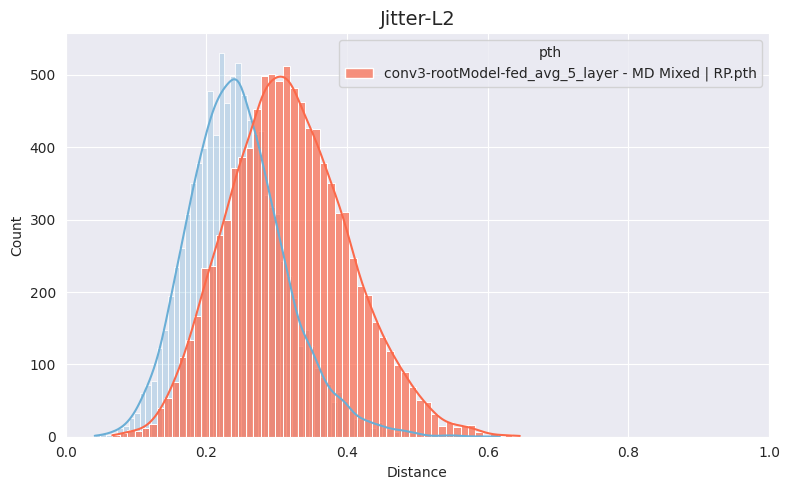

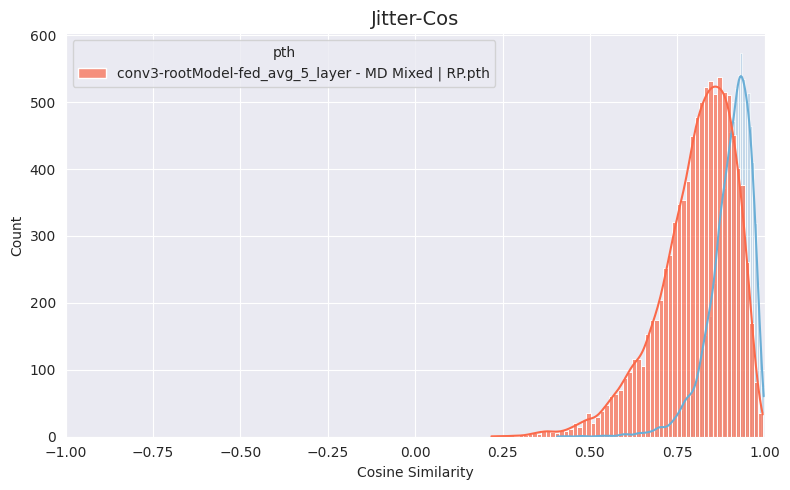

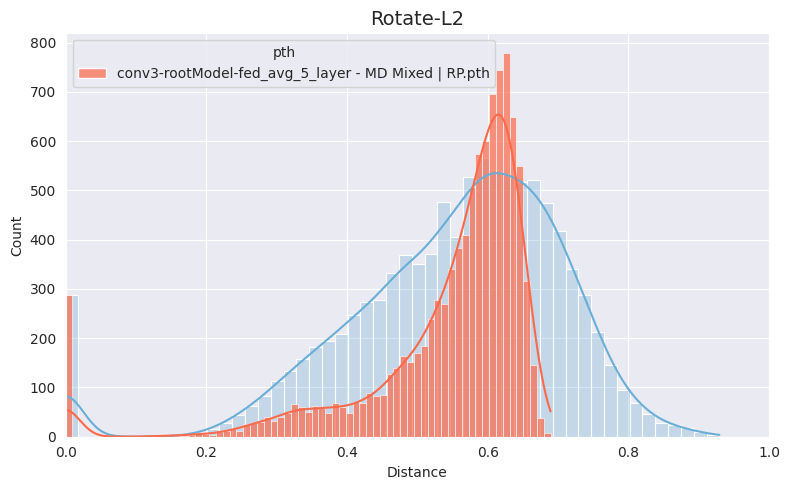

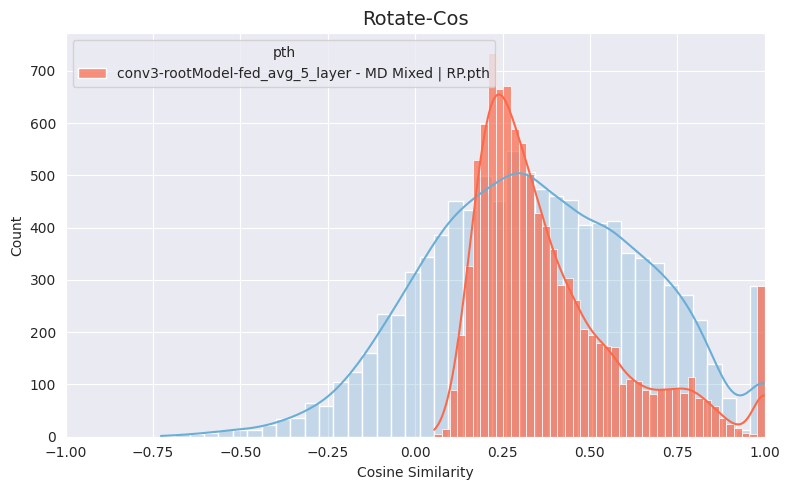

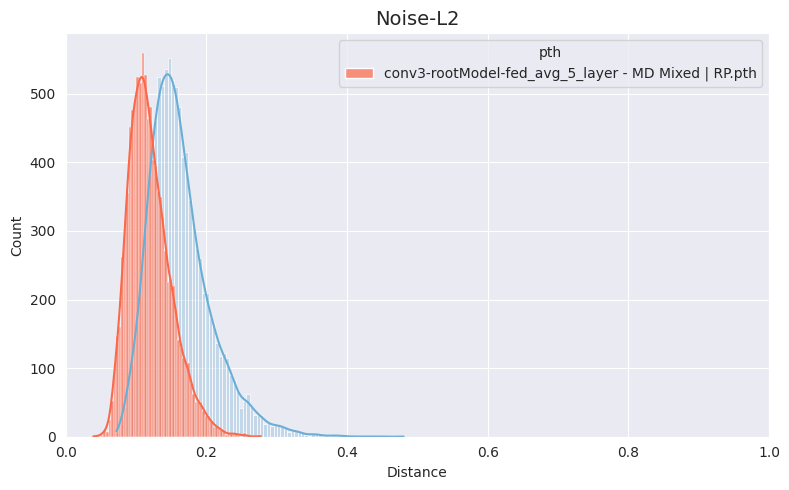

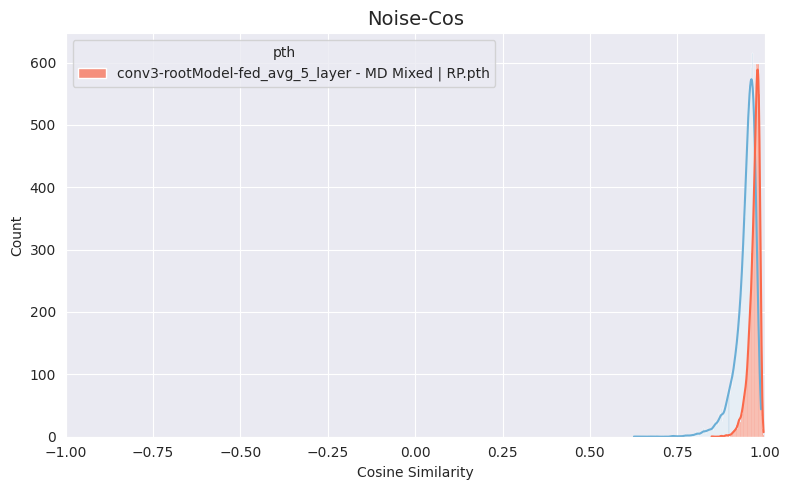

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from inference import inference
import copy

# CUDA ID
cuda_id = 1
records_l2 = []
records_cossim = []
records = []


for idx, path in enumerate(pth_path_list):
    print(f"\n===== [{idx+1}/{len(pth_path_list)}] {path} =====")

    # --------------------------------------------------
    # (2) 모델+데이터셋 연결 -> feature 추출
    # --------------------------------------------------
    inference_instance_A = inference(cudaId=cuda_id, dataset=dataset_A, model=model, pthPath=path)
    inference_instance_B = inference(cudaId=cuda_id, dataset=dataset_B, model=model, pthPath=path)
    inference_instance_C = inference(cudaId=cuda_id, dataset=dataset_C, model=model, pthPath=path)
    inference_instance_D = inference(cudaId=cuda_id, dataset=dataset_D, model=model, pthPath=path)
        
    # layer_names = ["conv1", "conv2", "conv3", "fc"]
    original_conv1_features, _ = extract_per_sample_features(model, inference_instance_A, "conv1")
    jitter_conv1_features,   _ = extract_per_sample_features(model, inference_instance_B, "conv1")
    rotated_conv1_features,  _ = extract_per_sample_features(model, inference_instance_C, "conv1")
    noised_conv1_features,   _ = extract_per_sample_features(model, inference_instance_D, "conv1")

    original_conv3_features, _ = extract_per_sample_features(model, inference_instance_A, "conv5")
    jitter_conv3_features,   _ = extract_per_sample_features(model, inference_instance_B, "conv5")
    rotated_conv3_features,  _ = extract_per_sample_features(model, inference_instance_C, "conv5")
    noised_conv3_features,   _ = extract_per_sample_features(model, inference_instance_D, "conv5")
    # --------------------------------------------------
    # (3) 샘플별 L2/Cosine Distance 계산
    # --------------------------------------------------
    # original vs. jitter
    conv1_jitter_l2_all, conv1_jitter_cos_all = calculate_per_sample_distances(original_conv1_features, jitter_conv1_features)
    # original vs. rotate
    conv1_rotate_l2_all, conv1_rotate_cos_all = calculate_per_sample_distances(original_conv1_features, rotated_conv1_features)
    # original vs. noise
    conv1_noise_l2_all, conv1_noise_cos_all   = calculate_per_sample_distances(original_conv1_features, noised_conv1_features)
    
    # original vs. jitter
    conv3_jitter_l2_all, conv3_jitter_cos_all = calculate_per_sample_distances(original_conv3_features, jitter_conv3_features)
    # original vs. rotate
    conv3_rotate_l2_all, conv3_rotate_cos_all = calculate_per_sample_distances(original_conv3_features, rotated_conv3_features)
    # original vs. noise
    conv3_noise_l2_all, conv3_noise_cos_all   = calculate_per_sample_distances(original_conv3_features, noised_conv3_features)

    # --------------------------------------------------
    # (4) plotting에 쓸 'raw' 거리/유사도 기록
    # --------------------------------------------------
    # 같은 목표(예: Jitter-L2)끼리는 hue='pth'로 묶어서 그리면 됨.
    # 여기서는 개별 샘플마다 row를 만들어 저장.
        
    # Jitter L2
    for val in conv1_jitter_l2_all:
        records.append({
                'pth': 'conv1-' + path.split('/')[-1],
                'dataset': 'Jitter',
                'metric': 'L2',
                'layer': 'conv1',
                'value': val
            })
    # Jitter Cosine
    for val in conv1_jitter_cos_all:
        records.append({
                'pth': 'conv1-' + path.split('/')[-1],
                'dataset': 'Jitter',
                'metric': 'Cos',
                'layer': 'conv1',
                'value': val
            })
    # Rotate L2
    for val in conv1_rotate_l2_all:
        records.append({
                'pth': 'conv1-' + path.split('/')[-1],
                'dataset': 'Rotate',
                'metric': 'L2',
                'layer': 'conv1',
                'value': val
            })
    # Rotate Cos
    for val in conv1_rotate_cos_all:
        records.append({
                'pth': 'conv1-' + path.split('/')[-1],
                'dataset': 'Rotate',
                'metric': 'Cos',
                'layer': 'conv1',
                'value': val
            })
    # Noise L2
    for val in conv1_noise_l2_all:
        records.append({
                'pth': 'conv1-' + path.split('/')[-1],
                'dataset': 'Noise',
                'metric': 'L2',
                'layer': 'conv1',
                'value': val
            })
    # Noise Cos
    for val in conv1_noise_cos_all:
        records.append({
                'pth': 'conv1-' + path.split('/')[-1],
                'dataset': 'Noise',
                'metric': 'Cos',
                'layer': 'conv1',
                'value': val
            })
    
    # CONV3
    # Jitter L2
    for val in conv3_jitter_l2_all:
        records.append({
                'pth': 'conv3-' + path.split('/')[-1],
                'dataset': 'Jitter',
                'metric': 'L2',
                'layer': 'conv3',
                'value': val
            })
    # Jitter Cosine
    for val in conv3_jitter_cos_all:
        records.append({
                'pth': 'conv3-' + path.split('/')[-1],
                'dataset': 'Jitter',
                'metric': 'Cos',
                'layer': 'conv3',
                'value': val
            })
    # Rotate L2
    for val in conv3_rotate_l2_all:
        records.append({
                'pth': 'conv3-' + path.split('/')[-1],
                'dataset': 'Rotate',
                'metric': 'L2',
                'layer': 'conv3',
                'value': val
            })
    # Rotate Cos
    for val in conv3_rotate_cos_all:
        records.append({
                'pth': 'conv3-' + path.split('/')[-1],
                'dataset': 'Rotate',
                'metric': 'Cos',
                'layer': 'conv3',
                'value': val
            })
    # Noise L2
    for val in conv3_noise_l2_all:
        records.append({
                'pth': 'conv3-' + path.split('/')[-1],
                'dataset': 'Noise',
                'metric': 'L2',
                'layer': 'conv3',
                'value': val
            })
    # Noise Cos
    for val in conv3_noise_cos_all:
        records.append({
                'pth': 'conv3-' + path.split('/')[-1],
                'dataset': 'Noise',
                'metric': 'Cos',
                'layer': 'conv3',
                'value': val
            })

# records -> DataFrame 변환
df = pd.DataFrame(records)
print("\n==> DataFrame preview:")
print(df.head())

# 시각화할 dataset & metric 쌍
combos = [
    ('Jitter', 'L2'),
    ('Jitter', 'Cos'),
    ('Rotate', 'L2'),
    ('Rotate', 'Cos'),
    ('Noise', 'L2'),
    ('Noise', 'Cos'),
]

# 6개의 plot을 각각 따로 출력
for i, (ds, mt) in enumerate(combos):
    subset_conv1 = copy.deepcopy(df[(df['dataset'] == ds) & (df['metric'] == mt) & (df['layer'] == 'conv1')])
    subset_conv3 = df[(df['dataset'] == ds) & (df['metric'] == mt) & (df['layer'] == 'conv3')]

    # 새로운 figure & axes 생성
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(
        data=subset_conv1, 
        x='value', 
        hue='pth', 
        kde=True,      # kde: 커널 밀도 곡선
        alpha=0.3,     # 투명도
        palette="Blues",
        ax=ax
    )
    
    sns.histplot(
        data=subset_conv3, 
        x='value', 
        hue='pth', 
        kde=True,      # kde: 커널 밀도 곡선
        alpha=0.7,     # 투명도
        palette="Reds",
        ax=ax
    )
    
    # x축 범위 설정
    if mt == 'L2':
        ax.set_xlim(0, 1)
    elif mt == 'Cos':
        ax.set_xlim(-1, 1)
    # 타이틀, 라벨 세팅
    ax.set_title(f"{ds}-{mt}", fontsize=14)
    ax.set_xlabel("Distance" if mt == 'L2' else "Cosine Similarity")

    # 그래프 표시 (한 번의 반복마다 하나씩 별도로 표시)
    plt.tight_layout()
    plt.show()


===== [1/3] ./trained_pth/rootModel-fed_avg - MD Mixed | RP.pth =====
Examin device online
cuda:1 available
examiner offline
Examin device online
cuda:1 available
examiner offline
Examin device online
cuda:1 available
examiner offline
Server validation Loss: 2.1364 | accuracy:  40.2600
Server validation Loss: 2.6028 | accuracy:  29.7500
Server validation Loss: 1.7362 | accuracy:  46.8100
Server validation Loss: 2.1364 | accuracy:  40.2600
Server validation Loss: 2.6028 | accuracy:  29.7500
Server validation Loss: 1.7362 | accuracy:  46.8100

===== [2/3] ./trained_pth/rootModel-fed_prox - MD Mixed | RP | Mu 0.001.pth =====
Examin device online
cuda:1 available
examiner offline
Examin device online
cuda:1 available
examiner offline
Examin device online
cuda:1 available
examiner offline
Server validation Loss: 2.1303 | accuracy:  40.6000
Server validation Loss: 2.6426 | accuracy:  28.9600
Server validation Loss: 1.7336 | accuracy:  46.5700
Server validation Loss: 2.1303 | accuracy:  40.6

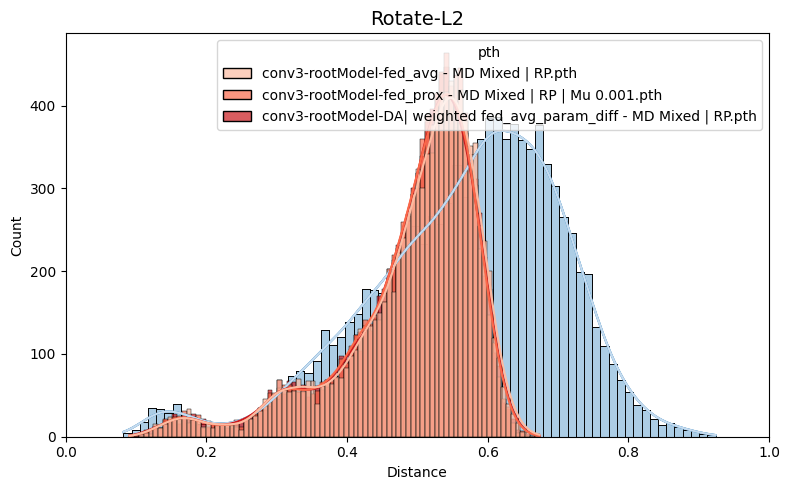

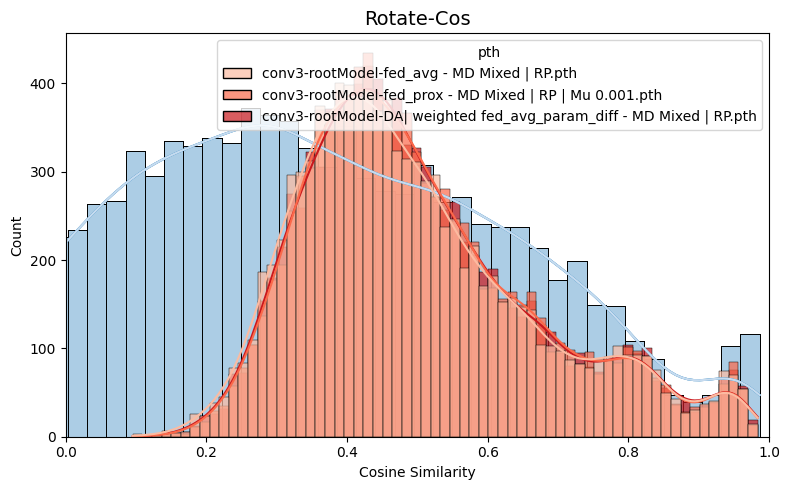

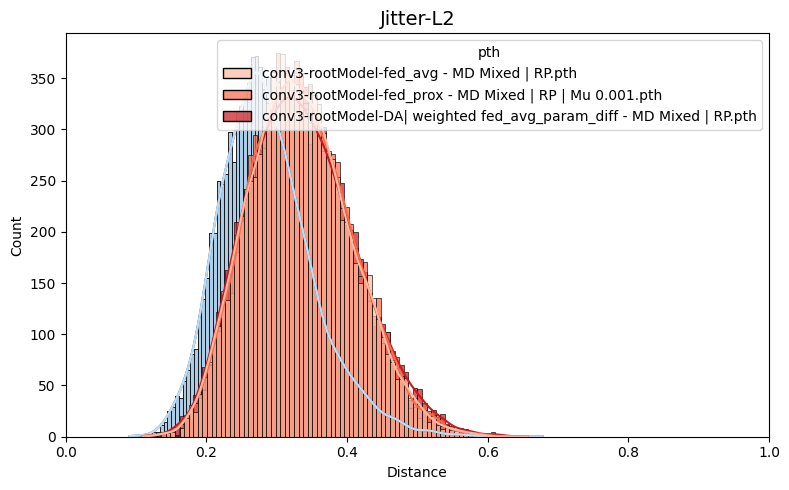

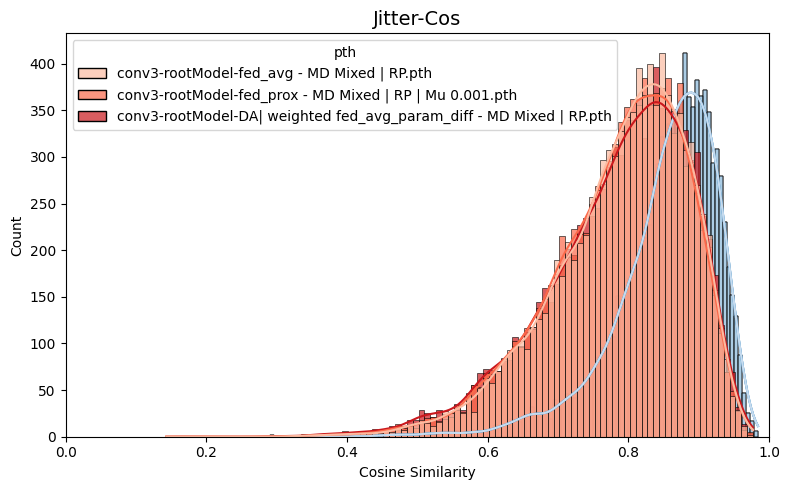

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from inference import inference
import copy

# CUDA ID
cuda_id = 1
records_l2 = []
records_cossim = []
records = []


for idx, path in enumerate(pth_path_list):
    print(f"\n===== [{idx+1}/{len(pth_path_list)}] {path} =====")

    # --------------------------------------------------
    # (2) 모델+데이터셋 연결 -> feature 추출
    # --------------------------------------------------
    # inference_instance_A = inference(cudaId=cuda_id, dataset=dataset_A, model=model, pthPath=path)
    inference_instance_B = inference(cudaId=cuda_id, dataset=dataset_B, model=model, pthPath=path)
    inference_instance_C = inference(cudaId=cuda_id, dataset=dataset_C, model=model, pthPath=path)
    inference_instance_D = inference(cudaId=cuda_id, dataset=dataset_D, model=model, pthPath=path)
        
    # layer_names = ["conv1", "conv2", "conv3", "fc"]
    # original_conv1_features, _ = extract_per_sample_features(model, inference_instance_A, "conv1")
    jitter_conv1_features,   _ = extract_per_sample_features(model, inference_instance_B, "conv1")
    rotate_conv1_features,  _ = extract_per_sample_features(model, inference_instance_C, "conv1")
    noise_conv1_features,   _ = extract_per_sample_features(model, inference_instance_D, "conv1")

    # original_conv3_features, _ = extract_per_sample_features(model, inference_instance_A, "conv3")
    jitter_conv3_features,   _ = extract_per_sample_features(model, inference_instance_B, "conv3")
    rotate_conv3_features,  _ = extract_per_sample_features(model, inference_instance_C, "conv3")
    noise_conv3_features,   _ = extract_per_sample_features(model, inference_instance_D, "conv3")
    # --------------------------------------------------
    # (3) 샘플별 L2/Cosine Distance 계산
    # --------------------------------------------------
    # A vs. B
    # conv1_B_l2_all, conv1_B_cos_all = calculate_per_sample_distances(A_conv1_features, B_conv1_features)
    # A vs. C
    conv1_C_l2_all, conv1_C_cos_all = calculate_per_sample_distances(noise_conv1_features, rotate_conv1_features)
    # A vs. D
    conv1_D_l2_all, conv1_D_cos_all   = calculate_per_sample_distances(noise_conv1_features, jitter_conv1_features)
    
    # A vs. B
    # conv3_B_l2_all, conv3_B_cos_all = calculate_per_sample_distances(A_conv3_features, B_conv3_features)
    # A vs. C
    conv3_C_l2_all, conv3_C_cos_all = calculate_per_sample_distances(noise_conv3_features, rotate_conv3_features)
    # A vs. D
    conv3_D_l2_all, conv3_D_cos_all   = calculate_per_sample_distances(noise_conv3_features, jitter_conv3_features)

    # --------------------------------------------------
    # (4) plotting에 쓸 'raw' 거리/유사도 기록
    # --------------------------------------------------
    # 같은 목표(예: B-L2)끼리는 hue='pth'로 묶어서 그리면 됨.
    # 여기서는 개별 샘플마다 row를 만들어 저장.
        
    # C L2
    for val in conv1_C_l2_all:
        records.append({
                'pth': 'conv1-' + path.split('/')[-1],
                'dataset': 'Rotate',
                'metric': 'L2',
                'layer': 'conv1',
                'value': val
            })
    # Rotate Cos
    for val in conv1_C_cos_all:
        records.append({
                'pth': 'conv1-' + path.split('/')[-1],
                'dataset': 'Rotate',
                'metric': 'Cos',
                'layer': 'conv1',
                'value': val
            })
    # D L2
    for val in conv1_D_l2_all:
        records.append({
                'pth': 'conv1-' + path.split('/')[-1],
                'dataset': 'Jitter',
                'metric': 'L2',
                'layer': 'conv1',
                'value': val
            })
    # Noise Cos
    for val in conv1_D_cos_all:
        records.append({
                'pth': 'conv1-' + path.split('/')[-1],
                'dataset': 'Jitter',
                'metric': 'Cos',
                'layer': 'conv1',
                'value': val
            })
    
    # CONV3
    # C L2
    for val in conv3_C_l2_all:
        records.append({
                'pth': 'conv3-' + path.split('/')[-1],
                'dataset': 'Rotate',
                'metric': 'L2',
                'layer': 'conv3',
                'value': val
            })
    # C Cos
    for val in conv3_C_cos_all:
        records.append({
                'pth': 'conv3-' + path.split('/')[-1],
                'dataset': 'Rotate',
                'metric': 'Cos',
                'layer': 'conv3',
                'value': val
            })
    # D L2
    for val in conv3_D_l2_all:
        records.append({
                'pth': 'conv3-' + path.split('/')[-1],
                'dataset': 'Jitter',
                'metric': 'L2',
                'layer': 'conv3',
                'value': val
            })
    # Noise Cos
    for val in conv3_D_cos_all:
        records.append({
                'pth': 'conv3-' + path.split('/')[-1],
                'dataset': 'Jitter',
                'metric': 'Cos',
                'layer': 'conv3',
                'value': val
            })

# records -> DataFrame 변환
df = pd.DataFrame(records)
print("\n==> DataFrame preview:")
print(df.head())

# 시각화할 dataset & metric 쌍
combos = [
    ('Rotate', 'L2'),
    ('Rotate', 'Cos'),
    ('Jitter', 'L2'),
    ('Jitter', 'Cos'),
]

# 6개의 plot을 각각 따로 출력
for i, (ds, mt) in enumerate(combos):
    subset_conv1 = copy.deepcopy(df[(df['dataset'] == ds) & (df['metric'] == mt) & (df['layer'] == 'conv1')])
    subset_conv3 = df[(df['dataset'] == ds) & (df['metric'] == mt) & (df['layer'] == 'conv3')]

    # 새로운 figure & axes 생성
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(
        data=subset_conv1, 
        x='value', 
        hue='pth', 
        kde=True,      # kde: 커널 밀도 곡선
        alpha=0.3,     # 투명도
        palette="Blues",
        ax=ax
    )
    
    sns.histplot(
        data=subset_conv3, 
        x='value', 
        hue='pth', 
        kde=True,      # kde: 커널 밀도 곡선
        alpha=0.7,     # 투명도
        palette="Reds",
        ax=ax
    )
    
    # x축 범위 설정
    ax.set_xlim(0, 1)

    # 타이틀, 라벨 세팅
    ax.set_title(f"{ds}-{mt}", fontsize=14)
    ax.set_xlabel("Distance" if mt == 'L2' else "Cosine Similarity")

    # 그래프 표시 (한 번의 반복마다 하나씩 별도로 표시)
    plt.tight_layout()
    plt.show()